In [1]:
'''
Nicole Osayande
261042925
Bzdok Lab MILA
'''
import os
import aesara
import scipy as sp
import arviz as az
import numpy as np
import pymc3 as pm
import pandas as pd
import xarray as xr
import seaborn as sns
from theano import shared
import arviz.labels as azl
from scipy.stats import zscore
from theano import tensor as tt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
#investigating overall cognition and neighbourhood poverty occurrence
data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/abcd_nda3_manuscript.csv', usecols=['nihtbx_totalcomp_uncorrected','reshist_addr1_adi_pov','abcd_site','site_id_l','race_ethnicity'], index_col=False)
print(data.shape)

(10843, 5)


In [3]:
val=data['reshist_addr1_adi_pov'].median()
data.loc[data['reshist_addr1_adi_pov'] <= val, 'reshist_addr1_adi_pov_bin'] = 0
data.loc[data['reshist_addr1_adi_pov'] > val, 'reshist_addr1_adi_pov_bin'] = 1 # poverty indicator

In [4]:
data['nihtbx_totalcomp_uncorrected_log']= np.log(data['nihtbx_totalcomp_uncorrected'])
col='nihtbx_totalcomp_uncorrected_log'
data['nihtbx_totalcomp_uncorrected_zscore'] = (data[col] - data[col].mean())/data[col].std(ddof=0)

In [5]:
race_idxs, race = pd.factorize(data.race_ethnicity)
data['race_enc'] = race_idxs #for shared object

state_idxs, state = pd.factorize(data.site_id_l)
data['state_enc'] = state_idxs #for shared object

In [6]:
race, state

(Index(['Hispanic', 'Asian', 'Other', 'Black', 'White'], dtype='object'),
 Index(['california', 'colorado', 'connecticut', 'florida', 'maryland',
        'michigan', 'minnesota', 'missouri', 'newyork', 'oklahoma', 'oregon',
        'pennsylvania', 'southcarolina', 'utah', 'vermont', 'virginia',
        'wisconsin'],
       dtype='object'))

In [7]:
#get input variables for shared object
abcd_race = data.race_enc.values
abcd_state = data.state_enc.values
pov = data.reshist_addr1_adi_pov_bin.values
target_values = data.nihtbx_totalcomp_uncorrected_zscore.values

In [8]:
#initialize shared objects for the model hierarchies and input variable 
abcd_race_ = shared(abcd_race)
abcd_state_ = shared(abcd_state)
pov_ = shared(pov)

In [9]:
#varying intercepts and varying slopes: 
#predicting overall cognition scores from neighbourhood poverty occurrence

RANDOM_SEED = 8924
np.random.seed(286)

coords = {"abcd_race": np.arange(len(race)),"abcd_state": np.arange(len(state))}


with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Hyperparameters
    a = pm.Normal("a", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    b = pm.Normal("b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5) 
   
    # Varying intercepts
    a_state = pm.Normal("a_state", mu=0.0, sigma=1.0, dims ='abcd_state')

    # Varying slopes
    b_race = pm.Normal("b_race", mu=0.0, sigma=1.0, dims ='abcd_race')
    

    # Expected value per city, theta
    # Non-centered reparameterization 
    theta = (a + a_state[abcd_state_] * sigma_a) + (b + b_race[abcd_race_] * sigma_b) * pov_
    
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    likelihood = pm.Normal("likelihood", theta, sigma=sigma, observed=target_values)
    
with varying_intercept_slope:
    varying_intercept_slope_idata = pm.sample(2000,
        tune=3000, init="adapt_diag", target_accept=0.99, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_race, a_state, sigma_b, b, sigma_a, a]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 1594 seconds.
The number of effective samples is smaller than 25% for some parameters.


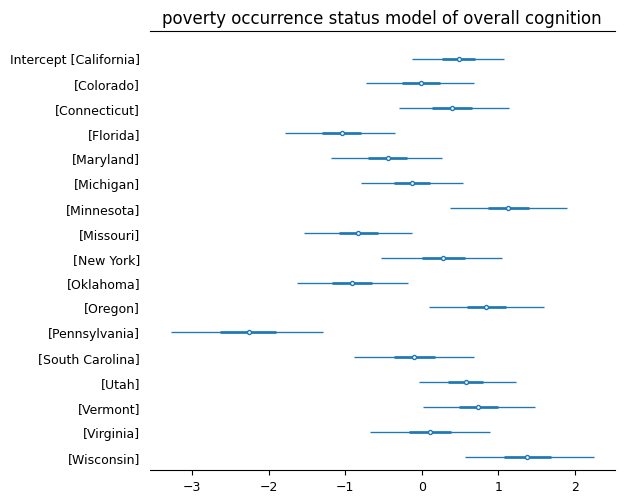

In [10]:
coords = {"abcd_state": [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]}
var_names = ["a_state"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"a_state": "Intercept "}
coord_map = {"abcd_state": { 0:'California', 1:'Colorado', 2:'Connecticut', 3:'Florida', 4:'Maryland',
       5:'Michigan', 6:'Minnesota', 7:'Missouri', 8:'New York', 9:'Oklahoma', 10:'Oregon',
       11:'Pennsylvania', 12:'South Carolina', 13:'Utah', 14:'Vermont', 15:'Virginia',
       16:'Wisconsin'}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes= az.plot_forest(varying_intercept_slope_idata, var_names=var_names,coords=coords,labeller=labeller,combined=True, textsize=9);
fig = axes.ravel()[0].figure
plt.title("poverty occurrence status model of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_plot_state_intercept_pov_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63741/2590831880.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


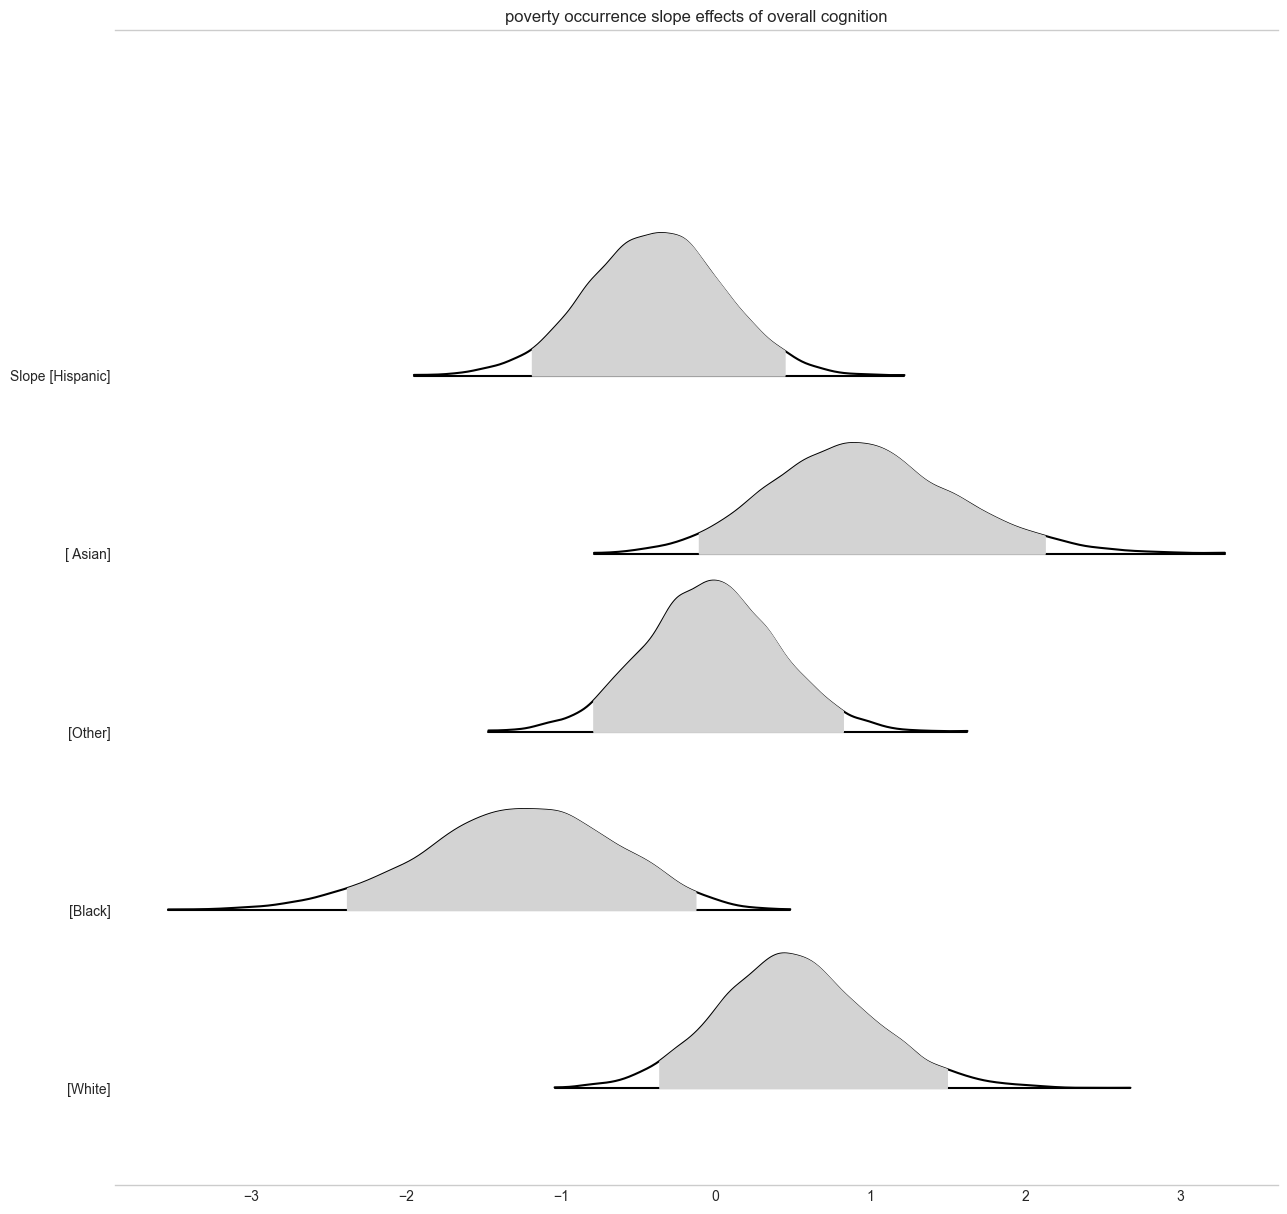

In [11]:
plt.style.use('seaborn-whitegrid')
coords = {"abcd_race": [0,1,2,3,4]}
var_names = ["b_race"]
# Define the var_name_map and coord_map for custom labels
var_name_map = {"b_race": "Slope "}
coord_map = {"abcd_race": { 0:"Hispanic", 1: " Asian", 2:"Other", 3:"Black", 4:"White"}}

# Create the MapLabeller object
labeller = azl.MapLabeller(var_name_map=var_name_map, coord_map=coord_map)

axes = az.plot_forest(varying_intercept_slope_idata,
                           kind='ridgeplot',var_names=var_names,coords=coords,labeller=labeller,
                           combined=True,
                           ridgeplot_truncate=False,
                           ridgeplot_overlap=0.7,
                           colors='lightgrey',
                           figsize=(15, 15))
fig = axes.ravel()[0].figure
plt.title("poverty occurrence slope effects of overall cognition")
#ax.set_xticklabels(['-4','-2','0','2','4'],size=28)
#fig.set_yticklabels(['','-3','-2','-1','0','1','2','3'],size=28)
fig.savefig('forest_ridge_plot_race_slope_pov_overall_cognition_results_f3.svg',transparent=True,dpi=600,format='svg')

In [12]:
with varying_intercept_slope:
    ppc = pm.sample_posterior_predictive(varying_intercept_slope_idata, var_names=["likelihood","a_state","b_race"], random_seed=RANDOM_SEED)
    

In [13]:
# Bayesian R2 score 
az.r2_score(target_values, ppc['likelihood'])

r2        0.373232
r2_std    0.003566
dtype: float64

In [14]:
#create ppc dataframe 
PP_COL = ['pp_cog_{}'.format(i) for i in range(ppc['likelihood'].shape[0])]
ppc_df = pd.DataFrame(ppc['likelihood'].T, columns=PP_COL)
ppc_df.shape

(10843, 8000)

In [15]:
# get race, state and neighbourhood poverty occurrence columns for ppc dataframe, reset index for merging dataframes
abcd_race_df = pd.DataFrame(data['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df = pd.DataFrame(data['site_id_l'],columns =['site_id_l']).reset_index(drop=True)
abcd_pov_df = pd.DataFrame(data['reshist_addr1_adi_pov_bin'],columns =['reshist_addr1_adi_pov_bin']).reset_index(drop=True)


In [16]:
ppc_df = pd.merge(abcd_race_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_state_df,ppc_df,left_index=True, right_index=True)
ppc_df = pd.merge(abcd_pov_df,ppc_df,left_index=True, right_index=True)


In [17]:
ppc_pov_race_mean = (ppc_df.groupby(['reshist_addr1_adi_pov_bin','race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_race_mean

pp_cog_0  pp_cog_1  pp_cog_2  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.278395  0.363673  0.274937   
                          Black           0.263015  0.165070  0.235185   
                          Hispanic        0.212281  0.228259  0.246973   
                          Other           0.253610  0.198463  0.227896   
                          White           0.284650  0.285929  0.259647   
1.0                       Asian           0.379781  0.517888  0.349896   
                          Black          -0.816814 -0.846548 -0.880488   
                          Hispanic       -0.350874 -0.345836 -0.348438   
                          Other          -0.078428 -0.214327 -0.196518   
                          White           0.109629  0.090843  0.193471   

                                          pp_cog_3  pp_cog_4  pp_cog_5  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.151978  0.265574  0.233113   
                          Black           0.269109  0.211305  0.227149   
                          Hispanic        0.188678  0.279321  0.214471   
                          Other           0.275181  0.219868  0.139550   
                          White           0.296883  0.288790  0.241424   
1.0                       Asian           0.358557  0.251026  0.322503   
                          Black          -0.923041 -0.897180 -0.932059   
                          Hispanic       -0.311347 -0.367781 -0.331278   
                          Other          -0.223055 -0.090433 -0.048478   
                          White           0.087561  0.170278  0.166552   

                                          pp_cog_6  pp_cog_7  pp_cog_8  \
reshist_addr1_adi_pov_bin race_ethnicity                                 
0.0                       Asian           0.218546  0.279320  0.318359   
                          Black           0.279549  0.243587  0.231970   
                          Hispanic        0.240113  0.187518  0.272152   
                          Other           0.215602  0.198441  0.259976   
                          White           0.259535  0.263385  0.280328   
1.0                       Asian           0.363900  0.364178  0.397071   
                          Black          -0.935702 -0.897709 -0.882698   
                          Hispanic       -0.340924 -0.319295 -0.300777   
                          Other          -0.266337 -0.328274 -0.223943   
                          White           0.146082  0.178599  0.119718   

                                          pp_cog_9  ...  pp_cog_7990  \
reshist_addr1_adi_pov_bin race_ethnicity            ...                
0.0                       Asian           0.338449  ...     0.253871   
                          Black           0.247856  ...     0.189511   
                          Hispanic        0.262228  ...     0.223533   
                          Other           0.226802  ...     0.200529   
                          White           0.288597  ...     0.276008   
1.0                       Asian           0.448588  ...     0.323171   
                          Black          -0.894645  ...    -0.876803   
                          Hispanic       -0.312087  ...    -0.331963   
                          Other          -0.220251  ...    -0.152091   
                          White           0.141821  ...     0.150126   

                                          pp_cog_7991  pp_cog_7992  \
reshist_addr1_adi_pov_bin race_ethnicity                             
0.0                       Asian              0.231205     0.322502   
                          Black              0.202677     0.176846   
                          Hispanic           0.338253     0.301264   
                          Other              0.221718     0.226562   
                          White              0.265234     0.266209   
1.0                 

In [18]:
ppc_pov_race_mean_summ=ppc_pov_race_mean.mean(axis=1)
ppc_pov_race_mean_summ

reshist_addr1_adi_pov_bin  race_ethnicity
0.0                        Asian             0.288020
                           Black             0.209122
                           Hispanic          0.243195
                           Other             0.242729
                           White             0.271764
1.0                        Asian             0.405498
                           Black            -0.890621
                           Hispanic         -0.346877
                           Other            -0.182066
                           White             0.136315
dtype: float64

In [19]:
ppc_race_mean = (ppc_df.groupby(['race_ethnicity']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_race_mean

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
race_ethnicity,,,,,,,,,,,,,,,,,,,,,
Asian,0.310907,0.413126,0.298974,0.218223,0.260909,0.261778,0.265157,0.306532,0.343600,0.373768,...,0.276094,0.331670,0.314589,0.256865,0.331194,0.509124,0.406951,0.300267,0.344415,0.222434
Black,-0.603253,-0.646477,-0.659837,-0.687265,-0.677951,-0.702798,-0.695358,-0.671991,-0.662246,-0.668689,...,-0.665914,-0.753681,-0.720209,-0.680467,-0.679855,-0.685392,-0.665088,-0.736280,-0.627032,-0.705807
Hispanic,-0.186030,-0.177789,-0.174151,-0.164982,-0.178363,-0.171528,-0.170845,-0.170943,-0.133071,-0.143976,...,-0.169360,-0.127357,-0.165741,-0.152894,-0.132722,-0.175485,-0.192755,-0.172105,-0.150031,-0.153550
Other,0.089500,-0.005559,0.018128,0.028926,0.066501,0.046616,-0.022598,-0.061889,0.020797,0.005845,...,0.026245,0.039643,0.034347,0.027834,0.034182,-0.003797,0.035468,0.007517,0.035618,0.031991
White,0.223537,0.217810,0.236540,0.223793,0.247408,0.215281,0.219920,0.233780,0.224247,0.237346,...,0.232053,0.211165,0.213221,0.210405,0.229816,0.206748,0.204065,0.232006,0.232752,0.219034


In [20]:
ppc_race_mean_summ = ppc_race_mean.mean(axis=1)

In [21]:
ppc_pov_state_mean = (ppc_df.groupby(['reshist_addr1_adi_pov_bin','site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_pov_state_mean_summ = ppc_pov_state_mean.mean(axis=1)


In [22]:
ppc_state_mean = (ppc_df.groupby(['site_id_l']).apply(lambda df: df[PP_COL].mean(axis=0)))
ppc_state_mean_summ = ppc_state_mean.mean(axis=1) #for the geomaps


In [23]:
ppc_pov_state_mean_summ_list=ppc_pov_state_mean_summ.to_numpy()
low_pov_state = ppc_pov_state_mean_summ_list[:17]
high_pov_state = ppc_pov_state_mean_summ_list[-17:]

In [24]:
mean_predictions_state = [low_pov_state,high_pov_state] 
  
# Create the pandas DataFrame 
mean_pred_state = pd.DataFrame(mean_predictions_state, columns=state) 
  
# print dataframe. 
mean_pred_state

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.303988,0.238490,0.292846,0.097804,0.178214,0.221177,0.391518,0.125648,0.276114,0.115787,0.353013,-0.068484,0.225295,0.315203,0.338188,0.253733,0.424185
1,-0.195330,-0.113314,-0.291996,-0.445100,-0.591874,-0.242901,0.102673,-0.441859,-0.254379,-0.385435,0.085620,-0.779298,-0.389929,0.103978,0.166706,-0.292256,-0.007679


In [25]:
ppc_pov_race_mean_summ_list=ppc_pov_race_mean_summ.to_numpy()
low_pov_race = ppc_pov_race_mean_summ_list[:5]
high_pov_race = ppc_pov_race_mean_summ_list[-5:]

In [26]:
# initialize list of lists 
mean_predictions_race = [low_pov_race,high_pov_race] 
  
# Create the pandas DataFrame 
mean_pred_race = pd.DataFrame(mean_predictions_race, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race

,Asian,Black,Hispanic,Other,White
0,0.288020,0.209122,0.243195,0.242729,0.271764
1,0.405498,-0.890621,-0.346877,-0.182066,0.136315


In [27]:
#auxiliary data
census_data = pd.read_csv('/Users/nicoleosa/Documents/ABCD_data/census_poststrat_dataset.csv', usecols=['state','PovertyLT100_FPL_score','County_population','race_ethnicity'], index_col=False)
print(census_data.shape)

(1042, 4)


In [28]:
val = census_data['PovertyLT100_FPL_score'].median()
census_data.loc[census_data['PovertyLT100_FPL_score'] < val, 'PovertyLT100_FPL_score_bin'] = 0
census_data.loc[census_data['PovertyLT100_FPL_score'] >= val, 'PovertyLT100_FPL_score_bin'] = 1

In [29]:
census = (census_data.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).County_population.agg(['sum']).reset_index())
census = census.rename(columns={'sum': 'freq'})
census

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0.0,767423
1,california,Asian,1.0,1067892
2,california,Black,0.0,3168044
3,california,Black,1.0,786431
4,california,Hispanic,0.0,6779394
...,...,...,...,...
136,wisconsin,Black,1.0,39628
137,wisconsin,Hispanic,0.0,88054
138,wisconsin,Other,0.0,183517
139,wisconsin,White,0.0,4001207


In [30]:
census['race_enc']=census['race_ethnicity']
census['race_enc'].replace(race,[0,1,2,3,4], inplace=True)
census['state_enc']=census['state']
census['state_enc'].replace(state,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16], inplace=True)
census.head()

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0.0,767423,1,0
1,california,Asian,1.0,1067892,1,0
2,california,Black,0.0,3168044,3,0
3,california,Black,1.0,786431,3,0
4,california,Hispanic,0.0,6779394,0,0


In [31]:
#fix theano shared tensor type error
census=census.astype({'PovertyLT100_FPL_score_bin':'uint8'})

In [33]:
#initialize poststrat vars
ps_abcd_race = census.race_enc.values
ps_abcd_state = census.state_enc.values
ps_pov = census.PovertyLT100_FPL_score_bin.values

#swap the model input variables 
abcd_race_.set_value(ps_abcd_race)
abcd_state_.set_value(ps_abcd_state)
pov_.set_value(ps_pov)

In [34]:
#re-run posterior predictive check with auxiliary census SDI data
with varying_intercept_slope:
    ppc2 = pm.sample_posterior_predictive(varying_intercept_slope_idata,var_names=['likelihood','a_state','b_race'],random_seed=RANDOM_SEED)
    

In [35]:
#create ppc dataframe 
PP_COL2 = ['pp_cog_{}'.format(i) for i in range(ppc2['likelihood'].shape[0])]
ppc_df2 = pd.DataFrame(ppc2['likelihood'].T, columns=PP_COL2)
ppc_df2.shape


(141, 8000)

In [36]:
censust=census
censust

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,race_enc,state_enc
0,california,Asian,0,767423,1,0
1,california,Asian,1,1067892,1,0
2,california,Black,0,3168044,3,0
3,california,Black,1,786431,3,0
4,california,Hispanic,0,6779394,0,0
...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,3,16
137,wisconsin,Hispanic,0,88054,0,16
138,wisconsin,Other,0,183517,2,16
139,wisconsin,White,0,4001207,4,16


In [37]:
# get race, state, and neighbourhood poverty occurrence columns for ppc dataframe, reset index for merging dataframes
abcd_race_df2 = pd.DataFrame(censust['race_ethnicity'],columns =['race_ethnicity']).reset_index(drop=True)
abcd_state_df2 = pd.DataFrame(censust['state'],columns =['state']).reset_index(drop=True)
abcd_pov_df2 = pd.DataFrame(censust['PovertyLT100_FPL_score_bin'],columns =['PovertyLT100_FPL_score_bin']).reset_index(drop=True)


In [38]:
ppc_df2 = pd.merge(censust['freq'],ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_pov_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_race_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2 = pd.merge(abcd_state_df2,ppc_df2,left_index=True, right_index=True)
ppc_df2

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-0.557447,1.449897,-0.456118,0.579073,-0.804742,-0.095836,...,1.012817,0.379946,0.555901,-0.276335,0.580589,-1.033488,-0.770347,0.978126,1.558452,0.120521
1,california,Asian,1,1067892,1.602150,0.582530,1.474610,-0.164216,0.770418,0.755321,...,-0.614185,-1.450737,-1.187113,0.544454,-0.655541,0.463791,1.566971,1.288272,0.209826,0.885006
2,california,Black,0,3168044,-1.459535,-1.850468,-0.547845,0.786985,-0.431479,1.154061,...,1.388513,0.885323,0.157146,-0.638244,0.470281,-0.777231,0.935235,-0.221714,0.504257,0.899415
3,california,Black,1,786431,-0.443251,-1.135592,-1.158509,-0.094729,-0.189420,0.123365,...,0.603709,0.212355,-0.414745,-0.978451,-2.059187,0.578977,-0.124966,-1.910227,-2.712271,-0.005250
4,california,Hispanic,0,6779394,1.250197,1.095463,-0.763858,0.074513,0.987061,0.462984,...,0.531650,0.076164,0.007163,1.253569,-0.850416,0.472205,1.939508,0.105765,0.364571,0.837136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-2.396877,0.479064,0.472920,-0.142938,1.093436,1.270425,...,-1.630241,0.399537,0.154211,-1.030448,-2.442266,-0.701864,0.008518,-1.197905,-2.910811,-0.031043
137,wisconsin,Hispanic,0,88054,-0.880632,0.825614,0.585397,0.581105,0.216130,-0.191072,...,0.936198,0.083152,-0.295982,-0.163134,2.519306,0.947696,-0.072309,0.325642,0.292666,0.179792
138,wisconsin,Other,0,183517,0.646733,0.069655,0.102285,0.016341,0.741345,0.921716,...,0.537392,0.871276,0.595699,-0.300956,-0.462664,0.415521,0.045026,2.027314,-0.334325,-0.978522
139,wisconsin,White,0,4001207,-1.214257,1.360553,0.092689,0.846869,1.085042,0.962922,...,0.394489,-0.537561,-0.061650,0.466722,1.018800,1.442519,1.013430,0.435958,1.393783,1.419373


In [39]:
#data-weighted for each category
ppc_poststrat_df = ppc_df2.groupby(['state','race_ethnicity','PovertyLT100_FPL_score_bin']).apply(lambda df: (df[PP_COL2]*df.freq.sum(axis=0)))
ppc_poststrat_df

pp_cog_0  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -4.277975e+05   
                          1                          1    1.710923e+06   
           Black          0                          2   -4.623871e+06   
                          1                          3   -3.485861e+05   
           Hispanic       0                          4    8.475580e+06   
...                                                                ...   
wisconsin  Black          1                          136 -9.498343e+04   
           Hispanic       0                          137 -7.754314e+04   
           Other          0                          138  1.186865e+05   
           White          0                          139 -4.858493e+06   
                          1                          140  3.925613e+05   

                                                              pp_cog_1  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    1.112685e+06   
                          1                          1    6.220794e+05   
           Black          0                          2   -5.862363e+06   
                          1                          3   -8.930644e+05   
           Hispanic       0                          4    7.426577e+06   
...                                                                ...   
wisconsin  Black          1                          136  1.898436e+04   
           Hispanic       0                          137  7.269861e+04   
           Other          0                          138  1.278285e+04   
           White          0                          139  5.443855e+06   
                          1                          140  1.383528e+05   

                                                              pp_cog_2  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -3.500354e+05   
                          1                          1    1.574724e+06   
           Black          0                          2   -1.735597e+06   
                          1                          3   -9.110871e+05   
           Hispanic       0                          4   -5.178496e+06   
...                                                                ...   
wisconsin  Black          1                          136  1.874088e+04   
           Hispanic       0                          137  5.154651e+04   
           Other          0                          138  1.877102e+04   
           White          0                          139  3.708674e+05   
                          1                          140  1.782158e+05   

                                                              pp_cog_3  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0    4.443936e+05   
                          1                          1   -1.753647e+05   
           Black          0                          2    2.493205e+06   
                          1                          3   -7.449773e+04   
           Hispanic       0                          4    5.051515e+05   
...                                                                ...   
wisconsin  Black          1                          136 -5.664334e+03   
           Hispanic       0                          137  5.116861e+04   
           Other          0                          138  2.998911e+03   
           White          0                          139  3.388496e+06   
                          1                          140 -7.283356e+04   

                                                              pp_cog_4  \
state      race_ethnicity PovertyLT100_FPL_score_bin                     
california Asian          0                          0   -6.17

In [40]:
#re-format groupby to remove multi-index
ppc_poststrat_df = ppc_poststrat_df.to_numpy()
ppc_poststrat_df = pd.DataFrame(ppc_poststrat_df, columns=PP_COL2)
ppc_poststrat_df

,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,pp_cog_6,pp_cog_7,pp_cog_8,pp_cog_9,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,-4.277975e+05,1.112685e+06,-3.500354e+05,4.443936e+05,-6.175777e+05,-7.354654e+04,1.534223e+05,9.182903e+05,9.605788e+05,4.458952e+04,...,7.772594e+05,2.915792e+05,4.266111e+05,-2.120662e+05,4.455577e+05,-7.931223e+05,-5.911823e+05,7.506362e+05,1.195992e+06,9.249078e+04
1,1.710923e+06,6.220794e+05,1.574724e+06,-1.753647e+05,8.227228e+05,8.066008e+05,1.292436e+06,7.534342e+05,1.986709e+06,1.451234e+06,...,-6.558835e+05,-1.549230e+06,-1.267708e+06,5.814177e+05,-7.000466e+05,4.952783e+05,1.673356e+06,1.375735e+06,2.240716e+05,9.450908e+05
2,-4.623871e+06,-5.862363e+06,-1.735597e+06,2.493205e+06,-1.366945e+06,3.656115e+06,3.679335e+06,3.537971e+06,-1.734159e+06,9.676077e+05,...,4.398869e+06,2.804741e+06,4.978448e+05,-2.021985e+06,1.489871e+06,-2.462302e+06,2.962866e+06,-7.023988e+05,1.597507e+06,2.849385e+06
3,-3.485861e+05,-8.930644e+05,-9.110871e+05,-7.449773e+04,-1.489657e+05,9.701820e+04,-1.584038e+06,-9.503511e+05,-9.901214e+05,-1.249731e+06,...,4.747756e+05,1.670025e+05,-3.261684e+05,-7.694842e+05,-1.619408e+06,4.553258e+05,-9.827687e+04,-1.502262e+06,-2.133014e+06,-4.128502e+03
4,8.475580e+06,7.426577e+06,-5.178496e+06,5.051515e+05,6.691677e+06,3.138751e+06,6.204875e+06,-2.645336e+06,8.874019e+06,1.894447e+05,...,3.604263e+06,5.163459e+05,4.856003e+04,8.498436e+06,-5.765305e+06,3.201265e+06,1.314869e+07,7.170205e+05,2.471569e+06,5.675272e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,-9.498343e+04,1.898436e+04,1.874088e+04,-5.664334e+03,4.333068e+04,5.034440e+04,-5.339393e+04,-1.836545e+04,-1.035010e+05,-5.047739e+04,...,-6.460321e+04,1.583284e+04,6.111085e+03,-4.083459e+04,-9.678212e+04,-2.781349e+04,3.375418e+02,-4.747058e+04,-1.153496e+05,-1.230166e+03
137,-7.754314e+04,7.269861e+04,5.154651e+04,5.116861e+04,1.903109e+04,-1.682462e+04,5.884824e+04,1.152006e+05,3.735461e+04,1.739022e+05,...,8.243596e+04,7.321881e+03,-2.606236e+04,-1.436463e+04,2.218350e+05,8.344845e+04,-6.367133e+03,2.867407e+04,2.577040e+04,1.583136e+04
138,1.186865e+05,1.278285e+04,1.877102e+04,2.998911e+03,1.360495e+05,1.691505e+05,2.421169e+05,7.197717e+04,-1.340996e+05,3.668675e+05,...,9.862051e+04,1.598939e+05,1.093209e+05,-5.523052e+04,-8.490677e+04,7.625510e+04,8.263030e+03,3.720467e+05,-6.135434e+04,-1.795754e+05
139,-4.858493e+06,5.443855e+06,3.708674e+05,3.388496e+06,4.341476e+06,3.852852e+06,4.600996e+06,3.289960e+05,2.019378e+06,3.513335e+06,...,1.578431e+06,-2.150891e+06,-2.466763e+05,1.867450e+06,4.076428e+06,5.771818e+06,4.054944e+06,1.744360e+06,5.576813e+06,5.679205e+06


In [41]:
ppc_df2_sub = ppc_df2.iloc[:, : 4] #get the input var, race, state and freq columns, to perform another group by for the final posstratification step
ppc_df2_sub

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq
0,california,Asian,0,767423
1,california,Asian,1,1067892
2,california,Black,0,3168044
3,california,Black,1,786431
4,california,Hispanic,0,6779394
...,...,...,...,...
136,wisconsin,Black,1,39628
137,wisconsin,Hispanic,0,88054
138,wisconsin,Other,0,183517
139,wisconsin,White,0,4001207


In [42]:
ppc_poststrat_df = pd.merge(ppc_df2_sub,ppc_poststrat_df,left_index=True, right_index=True) #merge the extracted colums with the dataframe from the first step of poststratification
ppc_poststrat_df

,state,race_ethnicity,PovertyLT100_FPL_score_bin,freq,pp_cog_0,pp_cog_1,pp_cog_2,pp_cog_3,pp_cog_4,pp_cog_5,...,pp_cog_7990,pp_cog_7991,pp_cog_7992,pp_cog_7993,pp_cog_7994,pp_cog_7995,pp_cog_7996,pp_cog_7997,pp_cog_7998,pp_cog_7999
0,california,Asian,0,767423,-4.277975e+05,1.112685e+06,-3.500354e+05,4.443936e+05,-6.175777e+05,-7.354654e+04,...,7.772594e+05,2.915792e+05,4.266111e+05,-2.120662e+05,4.455577e+05,-7.931223e+05,-5.911823e+05,7.506362e+05,1.195992e+06,9.249078e+04
1,california,Asian,1,1067892,1.710923e+06,6.220794e+05,1.574724e+06,-1.753647e+05,8.227228e+05,8.066008e+05,...,-6.558835e+05,-1.549230e+06,-1.267708e+06,5.814177e+05,-7.000466e+05,4.952783e+05,1.673356e+06,1.375735e+06,2.240716e+05,9.450908e+05
2,california,Black,0,3168044,-4.623871e+06,-5.862363e+06,-1.735597e+06,2.493205e+06,-1.366945e+06,3.656115e+06,...,4.398869e+06,2.804741e+06,4.978448e+05,-2.021985e+06,1.489871e+06,-2.462302e+06,2.962866e+06,-7.023988e+05,1.597507e+06,2.849385e+06
3,california,Black,1,786431,-3.485861e+05,-8.930644e+05,-9.110871e+05,-7.449773e+04,-1.489657e+05,9.701820e+04,...,4.747756e+05,1.670025e+05,-3.261684e+05,-7.694842e+05,-1.619408e+06,4.553258e+05,-9.827687e+04,-1.502262e+06,-2.133014e+06,-4.128502e+03
4,california,Hispanic,0,6779394,8.475580e+06,7.426577e+06,-5.178496e+06,5.051515e+05,6.691677e+06,3.138751e+06,...,3.604263e+06,5.163459e+05,4.856003e+04,8.498436e+06,-5.765305e+06,3.201265e+06,1.314869e+07,7.170205e+05,2.471569e+06,5.675272e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,wisconsin,Black,1,39628,-9.498343e+04,1.898436e+04,1.874088e+04,-5.664334e+03,4.333068e+04,5.034440e+04,...,-6.460321e+04,1.583284e+04,6.111085e+03,-4.083459e+04,-9.678212e+04,-2.781349e+04,3.375418e+02,-4.747058e+04,-1.153496e+05,-1.230166e+03
137,wisconsin,Hispanic,0,88054,-7.754314e+04,7.269861e+04,5.154651e+04,5.116861e+04,1.903109e+04,-1.682462e+04,...,8.243596e+04,7.321881e+03,-2.606236e+04,-1.436463e+04,2.218350e+05,8.344845e+04,-6.367133e+03,2.867407e+04,2.577040e+04,1.583136e+04
138,wisconsin,Other,0,183517,1.186865e+05,1.278285e+04,1.877102e+04,2.998911e+03,1.360495e+05,1.691505e+05,...,9.862051e+04,1.598939e+05,1.093209e+05,-5.523052e+04,-8.490677e+04,7.625510e+04,8.263030e+03,3.720467e+05,-6.135434e+04,-1.795754e+05
139,wisconsin,White,0,4001207,-4.858493e+06,5.443855e+06,3.708674e+05,3.388496e+06,4.341476e+06,3.852852e+06,...,1.578431e+06,-2.150891e+06,-2.466763e+05,1.867450e+06,4.076428e+06,5.771818e+06,4.054944e+06,1.744360e+06,5.576813e+06,5.679205e+06


In [43]:
#final step of poststratification - by race & poverty occurrence 
#data-weighted average
ppc_pov_race_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_race_poststrat


pp_cog_0  pp_cog_1  pp_cog_2  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.525156  0.391447  0.074813   
                           Black          -0.134428 -0.068828  0.284626   
                           Hispanic        0.960798  1.125504 -0.131747   
                           Other           0.993042  0.501228  0.357421   
                           White          -0.087321  0.949305 -0.620732   
1                          Asian           0.810365 -0.043763  0.985023   
                           Black          -0.501484 -0.585856 -1.165492   
                           Hispanic        0.476166 -0.828338 -0.067947   
                           Other          -0.929257  0.505372 -0.189314   
                           White           0.108882  0.122422  0.250396   

                                           pp_cog_3  pp_cog_4  pp_cog_5  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.091386 -0.381293  0.660090   
                           Black           0.402166  0.221682  0.593352   
                           Hispanic       -0.069970  0.264704  0.334582   
                           Other          -0.203728 -0.017001 -0.689215   
                           White           0.504208 -0.104710  0.580109   
1                          Asian           0.092099  0.484149  0.445576   
                           Black          -0.690038 -0.844832 -1.212287   
                           Hispanic       -0.695107 -0.071213 -0.614616   
                           Other           0.158388  0.205062  0.143538   
                           White           0.486977  0.608741  0.069392   

                                           pp_cog_6  pp_cog_7  pp_cog_8  \
PovertyLT100_FPL_score_bin race_ethnicity                                 
0                          Asian           0.974851 -0.035292 -0.300797   
                           Black           0.450617  0.218345  0.344717   
                           Hispanic        0.471097 -0.217727  0.591145   
                           Other           1.259882  0.635425 -0.253530   
                           White           0.272118  0.491076 -0.113580   
1                          Asian           0.824782  0.729386  0.573295   
                           Black          -1.013281 -0.658242 -1.053294   
                           Hispanic       -0.523331 -0.535365 -0.778508   
                           Other          -0.379726 -1.836060  0.029574   
                           White           0.294489  0.322002 -0.086638   

                                           pp_cog_9  ...  pp_cog_7990  \
PovertyLT100_FPL_score_bin race_ethnicity            ...                
0                          Asian           0.683932  ...     0.009098   
                           Black           0.479211  ...     0.372796   
                           Hispanic        0.210144  ...     0.361445   
                           Other           0.516957  ...    -0.354484   
                           White          -0.128293  ...     0.617246   
1                          Asian           0.725436  ...     0.607888   
                           Black          -0.835100  ...    -0.576623   
                           Hispanic        0.057623  ...    -1.141218   
                           Other           0.113187  ...    -0.455833   
                           White           0.137654  ...    -0.475717   

                                           pp_cog_7991  pp_cog_7992  \
PovertyLT100_FPL_score_bin race_ethnicity                             
0                          Asian              0.160592     0.264801   
                           Black              0.016014     0.171539   
                           Hispanic           0.278529     0.209885   
                           Other              0.907069     0.162608   
                           White     

In [44]:
#summarize race & poverty occurrence poststrat results
ppc_pov_race_poststrat_summ = ppc_pov_race_poststrat.mean(axis=1)
ppc_pov_race_poststrat_summ

PovertyLT100_FPL_score_bin  race_ethnicity
0                           Asian             0.200549
                            Black             0.206926
                            Hispanic          0.263816
                            Other             0.188159
                            White             0.232946
1                           Asian             0.390783
                            Black            -0.831064
                            Hispanic         -0.384845
                            Other            -0.169636
                            White             0.121240
dtype: float64

In [45]:
#final step postrat - by race
ppc_race_poststrat = ppc_poststrat_df.groupby(['race_ethnicity']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_race_poststrat_summ = ppc_race_poststrat.mean(axis=1)
ppc_race_poststrat_summ


race_ethnicity
Asian       0.248767
Black      -0.042494
Hispanic   -0.069601
Other      -0.028357
White       0.176258
dtype: float64

In [46]:
#for the lollipops
#final step poststrat - by state & ppoverty occurrence
ppc_pov_state_poststrat = ppc_poststrat_df.groupby(['PovertyLT100_FPL_score_bin','state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_pov_state_poststrat_summ = ppc_pov_state_poststrat.mean(axis=1)
ppc_pov_state_poststrat_summ

PovertyLT100_FPL_score_bin  state        
0                           california       0.312550
                            colorado         0.230864
                            connecticut      0.296046
                            florida          0.098601
                            maryland         0.171890
                            michigan         0.216701
                            minnesota        0.393060
                            missouri         0.123094
                            newyork          0.274605
                            oklahoma         0.109686
                            oregon           0.351848
                            pennsylvania    -0.065265
                            southcarolina    0.220342
                            utah             0.329216
                            vermont          0.345253
                            virginia         0.264454
                            wisconsin        0.428488
1                           california  

In [47]:
#for the geomaps
#final step poststrat - by state
ppc_state_poststrat = ppc_poststrat_df.groupby(['state']).apply(lambda df: (df[PP_COL2].sum(axis=0))/df.freq.sum(axis=0))
ppc_state_poststrat_summ = ppc_state_poststrat.mean(axis=1)
ppc_state_poststrat_summ

state
california       0.182723
colorado         0.184844
connecticut      0.296046
florida         -0.146829
maryland         0.030063
michigan         0.128644
minnesota        0.358067
missouri        -0.028185
newyork          0.068546
oklahoma        -0.066034
oregon           0.230958
pennsylvania    -0.113300
southcarolina   -0.042706
utah             0.292454
vermont          0.330809
virginia         0.186369
wisconsin        0.438512
dtype: float64

In [48]:
ppc_pov_state_poststrat_summ_list=ppc_pov_state_poststrat_summ.tolist()

In [49]:
#fill in missing value for connecticut
ppc_pov_state_poststrat_summ_list.insert(19,ppc_pov_state_mean_summ.iloc[19])

In [51]:
low_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[:17]
high_pov_state_poststrat = ppc_pov_state_poststrat_summ_list[-17:]

In [52]:
ppc_pov_race_poststrat_summ_list=ppc_pov_race_poststrat_summ.tolist()

In [53]:
low_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[:5]
high_pov_race_poststrat = ppc_pov_race_poststrat_summ_list[-5:]

In [54]:
mean_predictions_state_ps = [low_pov_state_poststrat,high_pov_state_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_state_ps = pd.DataFrame(mean_predictions_state_ps, columns=state) 
  
# print dataframe. 
mean_pred_state_ps

,california,colorado,connecticut,florida,maryland,michigan,minnesota,missouri,newyork,oklahoma,oregon,pennsylvania,southcarolina,utah,vermont,virginia,wisconsin
0,0.312550,0.230864,0.296046,0.098601,0.171890,0.216701,0.393060,0.123094,0.274605,0.109686,0.351848,-0.065265,0.220342,0.329216,0.345253,0.264454,0.428488
1,0.083904,-0.178025,-0.291996,-0.374626,-0.804885,0.047963,0.206814,-0.148974,-0.109467,-0.112746,0.155426,-0.229175,-0.168306,-0.064540,0.223953,-0.001779,0.475001


In [55]:
# initialize list of lists 
mean_predictions_race_ps = [low_pov_race_poststrat,high_pov_race_poststrat] 
  
# Create the pandas DataFrame 
mean_pred_race_ps = pd.DataFrame(mean_predictions_race_ps, columns=["Asian","Black","Hispanic","Other","White"]) 
  
# print dataframe. 
mean_pred_race_ps

,Asian,Black,Hispanic,Other,White
0,0.200549,0.206926,0.263816,0.188159,0.232946
1,0.390783,-0.831064,-0.384845,-0.169636,0.121240


In [56]:
quantiles = [0.5]

# Calculate quantiles for each row (state)
quantiles_per_state = np.quantile(ppc_state_mean, quantiles, axis=1)
quantiles_per_state_ps = np.quantile(ppc_state_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_state = quantiles_per_state.flatten().tolist()
quantiles_state_ps = quantiles_per_state_ps.flatten().tolist()

quantiles_state,quantiles_state_ps

([0.016860859269615152,
  0.12977768186783206,
  0.06849198686071502,
  -0.3106657712050681,
  -0.16196014393676267,
  -0.006222544470206786,
  0.31913679456472294,
  -0.14984569646879975,
  0.007090458138661845,
  -0.1453104968131167,
  0.20585698267800995,
  -0.6515171094416254,
  -0.06661207301582871,
  0.21700349195167112,
  0.28129185362755643,
  -0.005686716404729018,
  0.29832700846277305],
 [0.18442764809459739,
  0.1855429088708374,
  0.288946846594731,
  -0.14615974732444564,
  0.026569036939127256,
  0.12711748198833242,
  0.35381957280296067,
  -0.036133800969819406,
  0.06277706842038319,
  -0.06889810537350727,
  0.22370939426828934,
  -0.10847464806014316,
  -0.036274290471814595,
  0.29419501007204973,
  0.3332467407627031,
  0.17773076108487817,
  0.43684613490257773])

In [57]:
capitalized_states=['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']

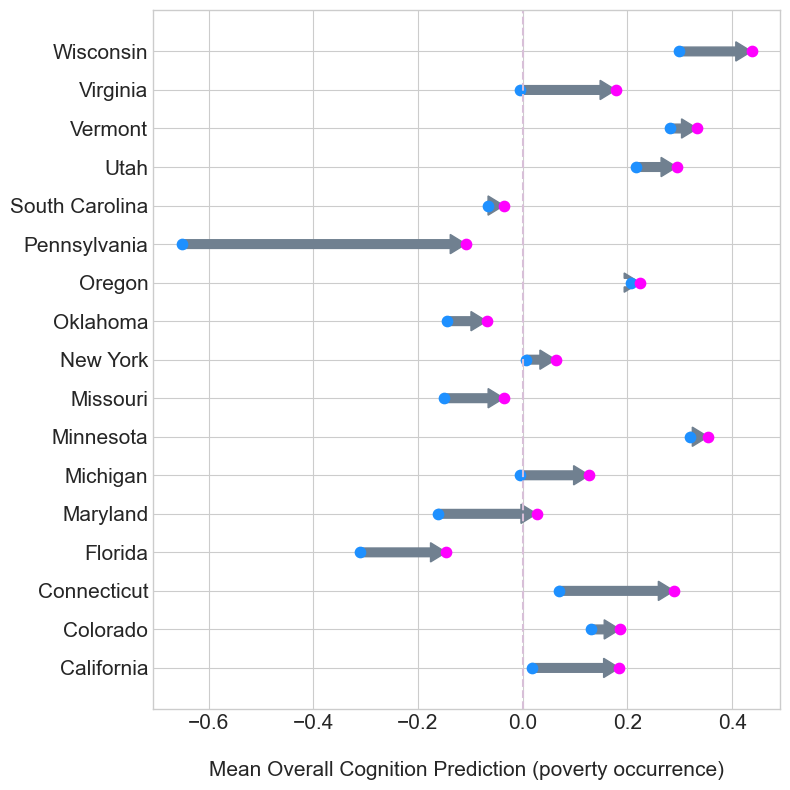

In [58]:
states = capitalized_states
quartiles_before_ps = quantiles_state   # mean prediction before poststratification
quartiles_after_ps = quantiles_state_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(8, 8))

# Plot arrows indicating change from before to after poststratification
for i in range(len(states)):
    plt.arrow(quartiles_before_ps[i], i, quartiles_after_ps[i] - quartiles_before_ps[i], 0, color='slategrey', width=0.225, head_width=0.5, head_length=0.03, length_includes_head=True)

# Plot second quartiles before poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_before_ps[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=55)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, state in enumerate(states):
    plt.scatter(quartiles_after_ps[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=55)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(states)), states,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (poverty occurrence)',size=15,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Poverty Occurrence Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_occur_overall_ps_state_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

In [59]:
quantiles_per_race = np.quantile(ppc_race_mean, quantiles, axis=1)
quantiles_per_race_ps = np.quantile(ppc_race_poststrat, quantiles, axis=1)

# Convert to list of lists
quantiles_race = quantiles_per_race.flatten().tolist()
quantiles_race_ps = quantiles_per_race_ps.flatten().tolist()

quantiles_race,quantiles_race_ps

([0.326328586735935,
  -0.6727747416872994,
  -0.1743647237132943,
  0.03277409929589886,
  0.22461944639730558],
 [0.25066521702610256,
  -0.046841875652326996,
  -0.07189858199825325,
  -0.025935870652631317,
  0.1755776576769416])

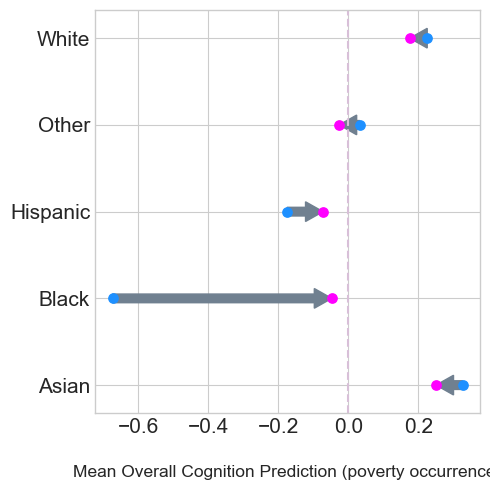

In [60]:
races = ['Asian','Black','Hispanic','Other','White']
quartiles_before_ps_r = quantiles_race   # mean prediction before poststratification
quartiles_after_ps_r = quantiles_race_ps  # mean prediction after poststratification

# Plotting
plt.figure(figsize=(5, 5))

# Plot arrows indicating change from before to after poststratification
for i in range(len(races)):
    plt.arrow(quartiles_before_ps_r[i], i, quartiles_after_ps_r[i] - quartiles_before_ps_r[i], 0, color='slategrey', width=0.10, head_width=0.227, head_length=0.05, length_includes_head=True)

# Plot second quartiles before poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_before_ps_r[i], i, marker='o', color='dodgerblue', label='Before PS' if i == 0 else "",s=45)  # Dot for second quartile

# Plot second quartiles after poststratification
for i, race in enumerate(races):
    plt.scatter(quartiles_after_ps_r[i], i, marker='o', color='fuchsia', label='After PS' if i == 0 else "",s=45)  # Dot for second quartile

# Add vertical dashed line at x = 0
plt.axvline(x=0, color='thistle', linestyle='--')

plt.yticks(range(len(races)), races,size=15)
plt.xticks(size=15)
plt.xlabel('Mean Overall Cognition Prediction (poverty occurrence)',size=12.5,labelpad=20)
#plt.title('Mean Predictions of Overall Cognition based on Poverty Occurrence Before and After Poststratification')
plt.grid(True)
#plt.legend()
#plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.tight_layout()
plt.savefig('arrow_plot_pov_occur_overall_ps_race_cognition_results_f4.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()

/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63741/3691634154.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63741/3691634154.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


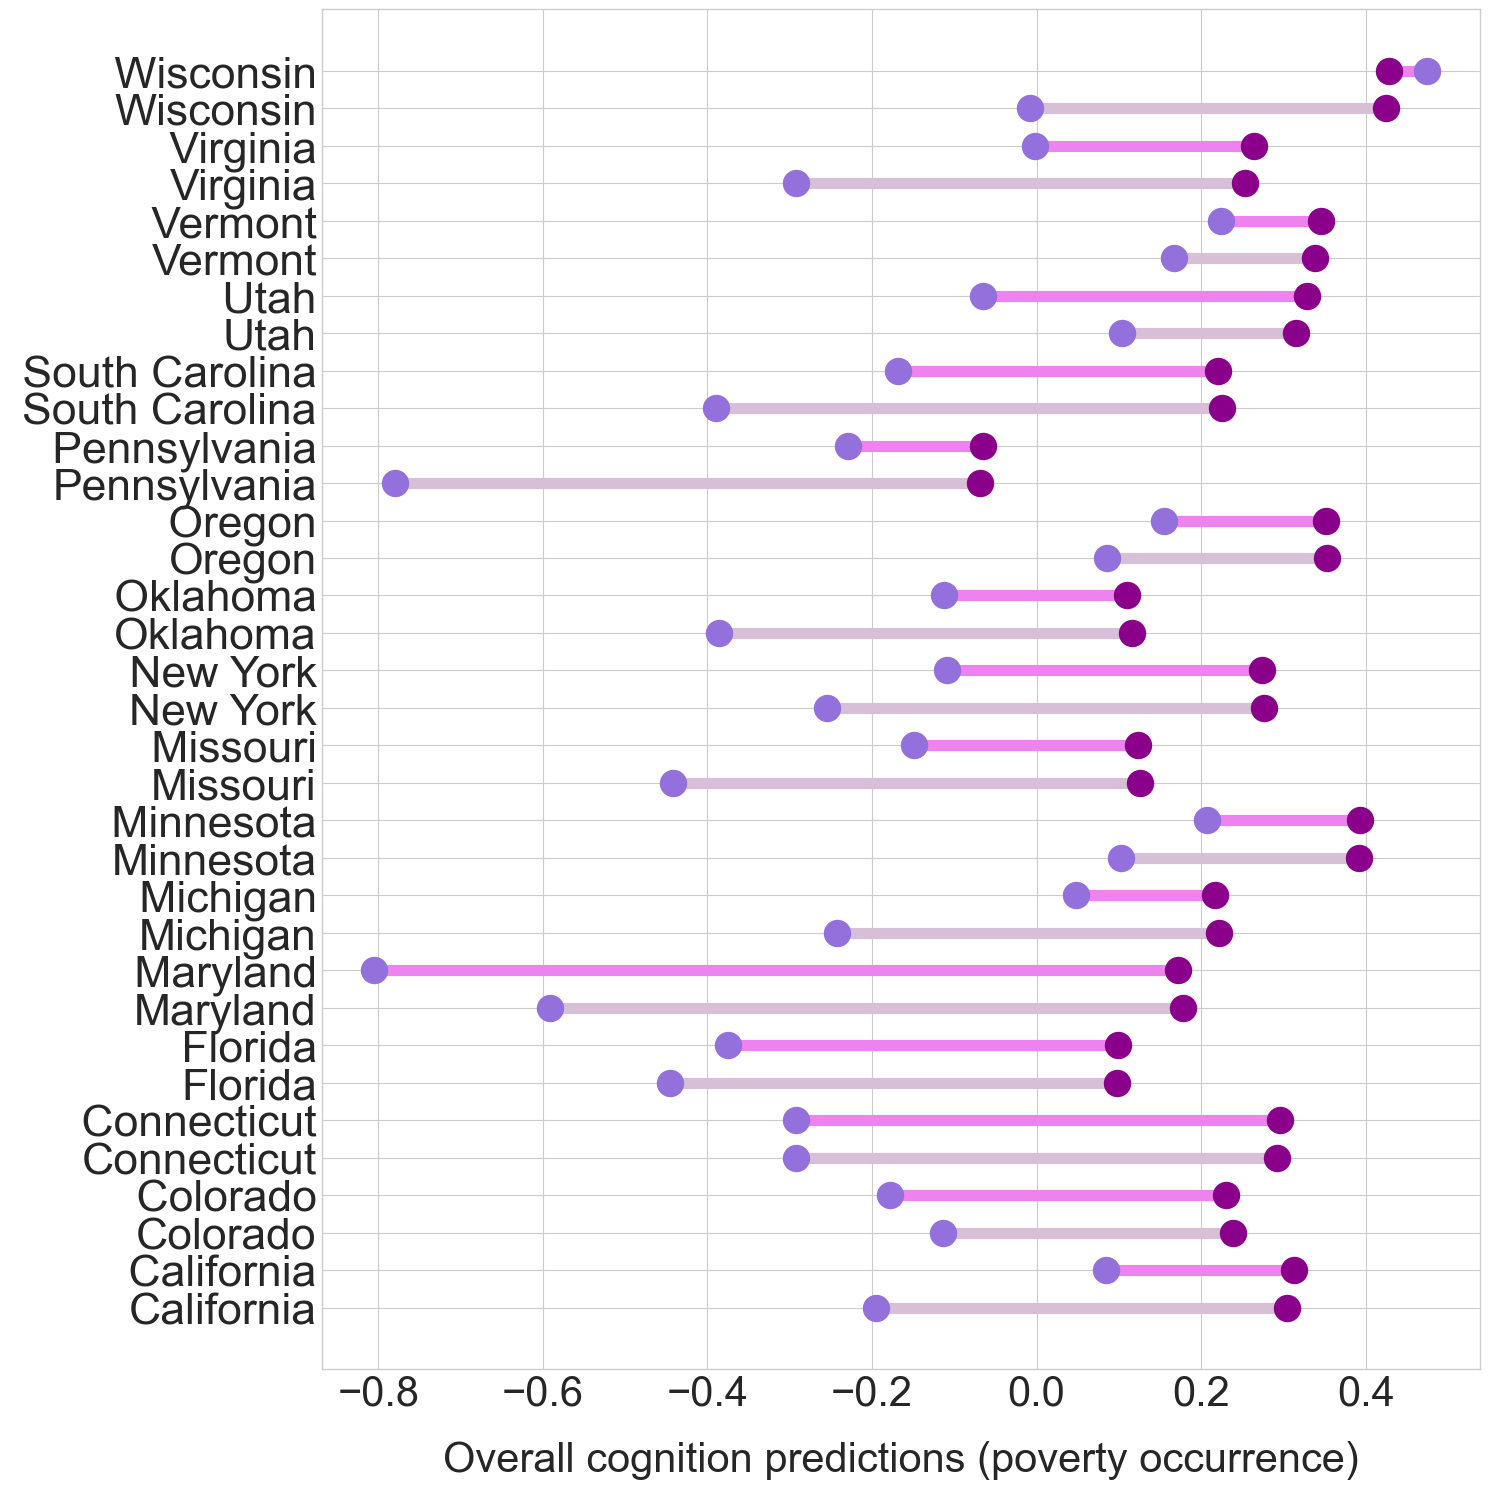

In [61]:
datas=mean_predictions_state
datas2=mean_predictions_state_ps
state_names = ['California',
 'Colorado',
 'Connecticut',
 'Florida',
 'Maryland',
 'Michigan',
 'Minnesota',
 'Missouri',
 'New York',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'South Carolina',
 'Utah',
 'Vermont',
 'Virginia',
 'Wisconsin']
state_names2 = [' California',
 ' Colorado',
 ' Connecticut',
 ' Florida',
 ' Maryland',
 ' Michigan',
 ' Minnesota',
 ' Missouri',
 ' New York',
 ' Oklahoma',
 ' Oregon',
 ' Pennsylvania',
 ' South Carolina',
 ' Utah',
 ' Vermont',
 ' Virginia',
 ' Wisconsin']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for state_name, state_values,state_name2, state_values2 in zip(state_names, np.array(datas).T,state_names2, np.array(datas2).T):
    plt.plot(state_values, [state_name, state_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(state_values2, [state_name2, state_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(state_values[0], state_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values[1], state_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(state_values2[0], state_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(state_values2[1], state_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (poverty occurrence)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each State')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_occur_overall_ps_state_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()


/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63741/2664704290.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
/var/folders/vm/f5ddqzq57cnd0dhfcyvb42440000gn/T/ipykernel_63741/2664704290.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state


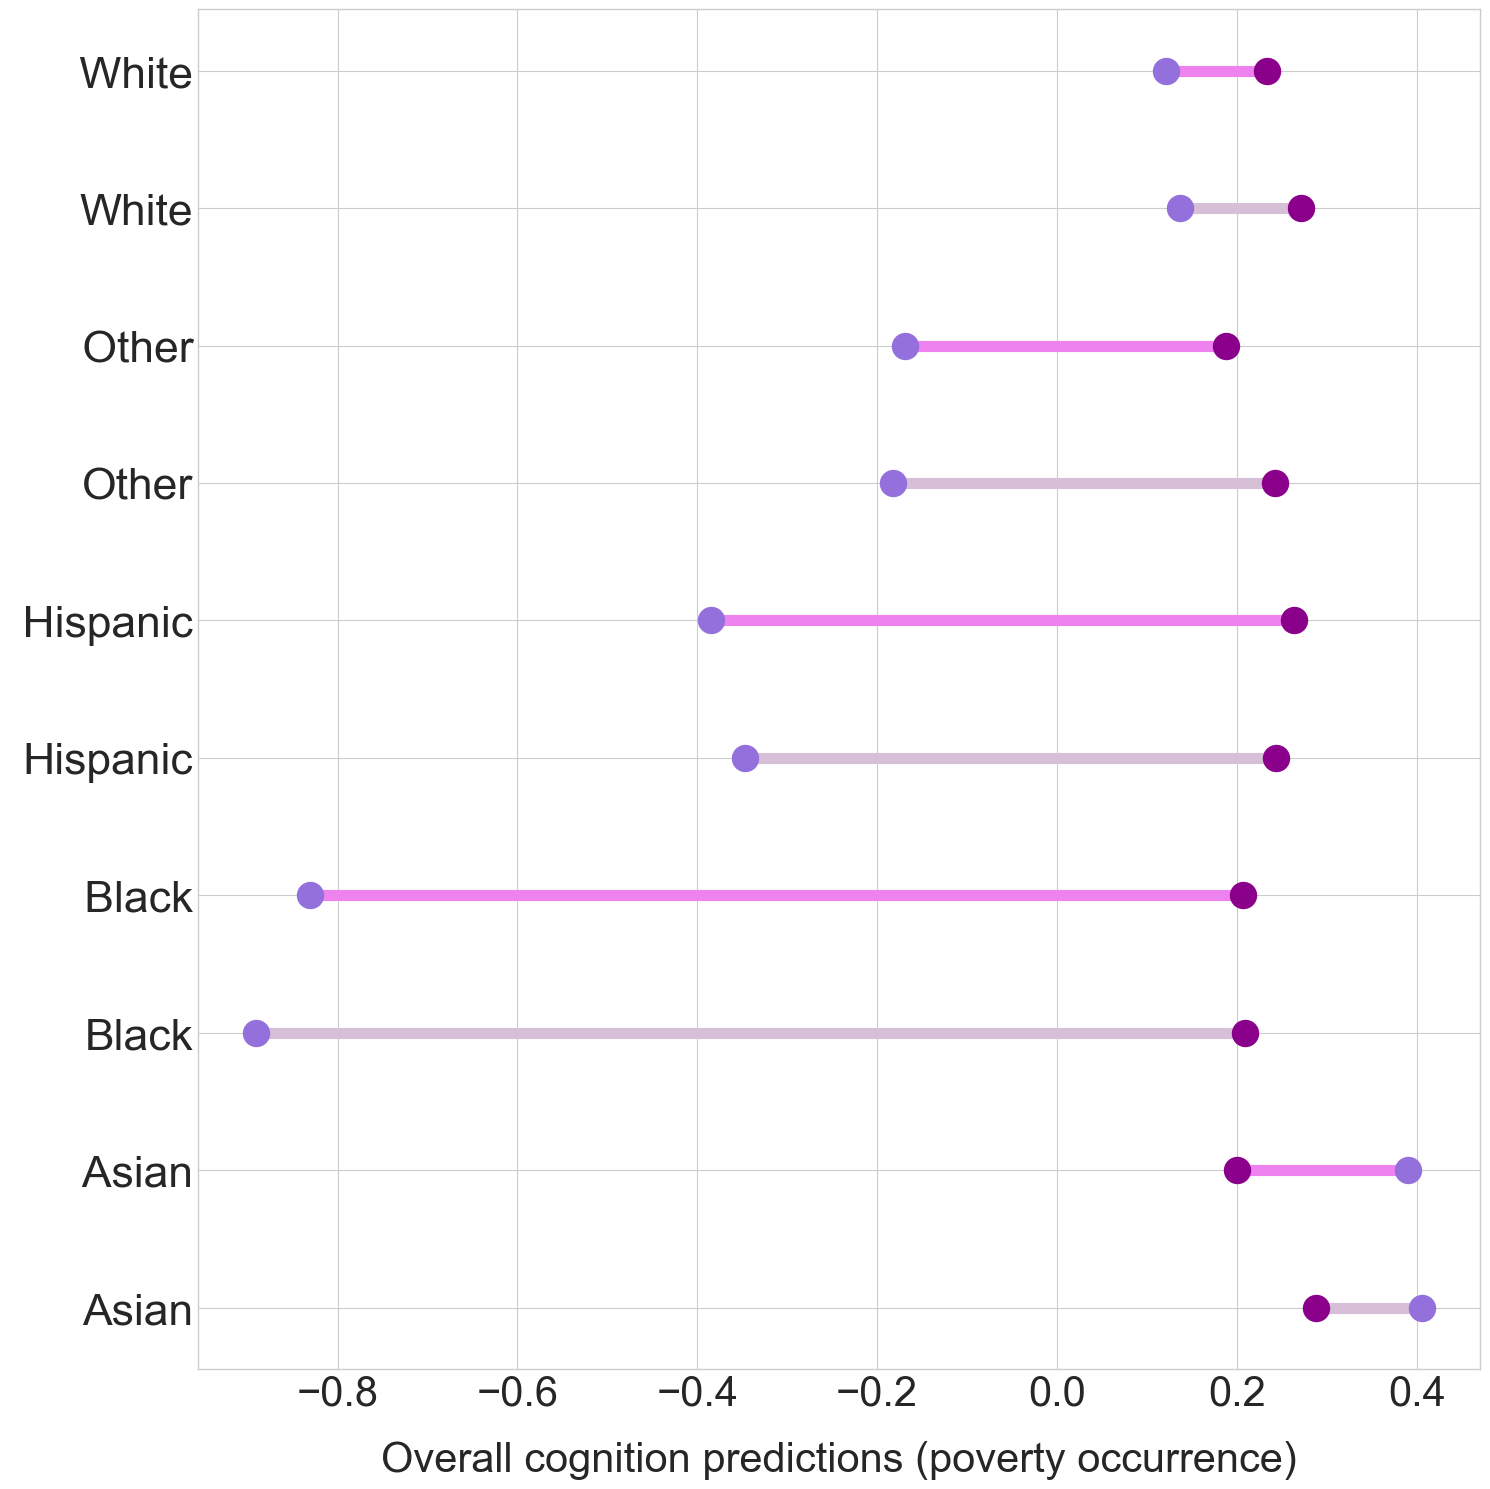

In [62]:
datas_r=mean_predictions_race
datas_r2=mean_predictions_race_ps
race_names = ['Asian',
 'Black',
 'Hispanic',
 'Other',
 'White']
#dont forget the blank space in front of the name so not overwritten
race_names2 = [' Asian',
 ' Black',
 ' Hispanic',
 ' Other',
 ' White']
# Plotting
plt.figure(figsize=(15, 15))

# Transpose the data matrix to iterate over states
for race_name, race_values,race_name2, race_values2 in zip(race_names, np.array(datas_r).T,race_names2, np.array(datas_r2).T):
    plt.plot(race_values, [race_name, race_name], 'k-',color='thistle', linewidth=8,zorder=1,label='before PS')  # Connect the points for the state
    plt.plot(race_values2, [race_name2, race_name2], 'k-',color='violet', linewidth=8,zorder=1,label='after PS')  # Connect the points for the state
    
    plt.scatter(race_values[0], race_name, color='darkmagenta', label='low pov oc', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values[1], race_name, color='mediumpurple', label='high pov oc', s=350,zorder=2)  # Plot value 2 for the state
    
    plt.scatter(race_values2[0], race_name2, color='darkmagenta', s=350,zorder=2)  # Plot value 1 for the state
    plt.scatter(race_values2[1], race_name2, color='mediumpurple', s=350,zorder=2)  # Plot value 2 for the state
    
plt.xticks(size=30)
plt.yticks(size=32)
plt.xlabel('Overall cognition predictions (poverty occurrence)',size= 30,labelpad=20)
#plt.ylabel('States',size=25)
#plt.title('Values for Each Race')
#plt.legend(['before PS','after PS','low pov oc', 'high pov oc'],loc='upper right', bbox_to_anchor=(1.5, 1.0),frameon=True)
plt.grid(True)
plt.tight_layout()
plt.savefig('lolli_plot_pov_occur_overall_ps_race_cognition_results_f5.svg',transparent=True,dpi=600, bbox_inches='tight',format='svg')
plt.show()